In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
import MetaTrader5 as mt5
from datetime import datetime
import talib
from sklearn.metrics import mean_squared_error, mean_absolute_error



## Dataset Selection

In [2]:
# connect to MetaTrader5 Terminal
mt5.initialize()

# login to your Trading Account - sign up in the description
login = 51550448
password = '*******'
server = 'ICMarketsSC'

mt5.login(login, password, server)

True

In [17]:
import MetaTrader5 as mt5
import pandas as pd
import talib as ta

def get_ohlc(symbol, timeframe, start_datetime, end_datetime):
    # Retrieve OHLC data from the MT5 account
    ohlc = mt5.copy_rates_range(symbol, timeframe, start_datetime, end_datetime)
    
    # Convert the data to a DataFrame
    ohlc_df = pd.DataFrame(ohlc)
    ohlc_df['time'] = pd.to_datetime(ohlc_df['time'], unit='s')
    
    # Include volume and indicator data in the returned DataFrame
    return ohlc_df[['time', 'open', 'high', 'low', 'close', 'tick_volume']]

In [18]:
symbol = 'BTCUSD'
timeframe = mt5.TIMEFRAME_H1
start_datetime = datetime(2020, 1, 1)
end_datetime = datetime(2024, 1, 1)

ohlc_df = get_ohlc(symbol, timeframe, start_datetime, end_datetime)
ohlc_df

,time,open,high,low,close,tick_volume
0,2019-12-31 19:00:00,7184.29,7186.79,7115.29,7132.79,62660
1,2019-12-31 20:00:00,7133.29,7145.29,7109.29,7140.79,53960
2,2020-01-02 00:00:00,7128.58,7207.29,7128.58,7171.29,61776
3,2020-01-02 01:00:00,7171.29,7178.29,7150.79,7172.79,41760
4,2020-01-02 02:00:00,7172.79,7184.79,7156.29,7181.29,20110
...,...,...,...,...,...,...
31787,2023-12-31 14:00:00,42494.94,42631.37,42317.37,42400.53,7071
31788,2023-12-31 15:00:00,42400.53,42516.44,42344.63,42432.06,6976
31789,2023-12-31 16:00:00,42430.39,42513.90,42386.44,42504.83,7411
31790,2023-12-31 17:00:00,42504.73,42571.03,42321.57,42439.52,7755


In [19]:
data = ohlc_df.copy()

## Preprocessing and Feature Engineering

In [20]:
# Handle missing values
data = data.dropna()

In [21]:
#Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'tick_volume']])
normalized_data = pd.DataFrame(normalized_data, columns=['open', 'high', 'low', 'close', 'tick_volume'])

In [22]:
# Calculate technical indicators
normalized_data['SMA_30'] = talib.SMA(normalized_data['close'], timeperiod=30)
normalized_data['SMA_50'] = talib.SMA(normalized_data['close'], timeperiod=50)
normalized_data['EMA_30'] = talib.EMA(normalized_data['close'], timeperiod=30)
normalized_data['EMA_50'] = talib.EMA(normalized_data['close'], timeperiod=50)
normalized_data['RSI_14'] = talib.RSI(normalized_data['close'], timeperiod=14)
normalized_data['MACD'], normalized_data['MACD_Signal'], normalized_data['MACD_Hist'] = talib.MACD(normalized_data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
normalized_data['Upper_BB'], normalized_data['Middle_BB'], normalized_data['Lower_BB'] = talib.BBANDS(normalized_data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
normalized_data['ATR_14'] = talib.ATR(normalized_data['high'], normalized_data['low'], normalized_data['close'], timeperiod=14)
normalized_data['SlowK'], normalized_data['SlowD'] = talib.STOCH(normalized_data['high'], normalized_data['low'], normalized_data['close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

In [23]:
# Drop rows with NaN values resulting from indicator calculations
normalized_data = normalized_data.dropna()

In [24]:
# Additional feature engineering
normalized_data['Price_Change'] = normalized_data['close'].pct_change()
normalized_data['Volatility'] = normalized_data['close'].rolling(window=30).std()
normalized_data['Volume_Change'] = normalized_data['tick_volume'].pct_change()

In [25]:
# Drop rows with NaN values resulting from new feature calculations
normalized_data = normalized_data.dropna()

In [26]:
normalized_data.head()

,open,high,low,close,tick_volume,SMA_30,SMA_50,EMA_30,EMA_50,RSI_14,...,MACD_Hist,Upper_BB,Middle_BB,Lower_BB,ATR_14,SlowK,SlowD,Price_Change,Volatility,Volume_Change
78,0.059406,0.051737,0.063771,0.059534,0.039383,0.054168,0.052184,0.054427,0.052687,82.619997,...,0.000484,0.059243,0.055052,0.050862,0.007560,-44.725887,-28.239964,-0.001489,0.002324,-0.231004
79,0.059286,0.051442,0.063669,0.059458,0.024777,0.054493,0.052501,0.054752,0.052952,81.785030,...,0.000461,0.059883,0.055358,0.050834,0.007598,-45.138327,-39.772606,-0.001270,0.002361,-0.370865
80,0.059210,0.051213,0.062633,0.058666,0.038586,0.054748,0.052781,0.055004,0.053176,73.416508,...,0.000358,0.060290,0.055593,0.050896,0.007644,-37.769821,-42.544678,-0.013316,0.002386,0.557333
81,0.058413,0.050854,0.062828,0.059124,0.029797,0.055018,0.053072,0.055270,0.053409,75.008209,...,0.000290,0.060727,0.055848,0.050969,0.007656,-34.241823,-39.049990,0.007800,0.002408,-0.227781
82,0.058882,0.050759,0.063206,0.059060,0.020485,0.055275,0.053282,0.055515,0.053631,74.338039,...,0.000214,0.061099,0.056093,0.051086,0.007707,-31.449575,-34.487073,-0.001082,0.002414,-0.312504


In [27]:
# Check for NaNs
print(normalized_data.isna().sum())

# Check for infinities
print(np.isinf(normalized_data).sum())

# Drop any rows with NaNs or infinities
normalized_data = normalized_data.replace([np.inf, -np.inf], np.nan)
normalized_data = normalized_data.dropna()


open             0
high             0
low              0
close            0
tick_volume      0
SMA_30           0
SMA_50           0
EMA_30           0
EMA_50           0
RSI_14           0
MACD             0
MACD_Signal      0
MACD_Hist        0
Upper_BB         0
Middle_BB        0
Lower_BB         0
ATR_14           0
SlowK            0
SlowD            0
Price_Change     0
Volatility       0
Volume_Change    0
dtype: int64
open             0
high             0
low              0
close            0
tick_volume      0
SMA_30           0
SMA_50           0
EMA_30           0
EMA_50           0
RSI_14           0
MACD             0
MACD_Signal      0
MACD_Hist        0
Upper_BB         0
Middle_BB        0
Lower_BB         0
ATR_14           0
SlowK            0
SlowD            0
Price_Change     1
Volatility       0
Volume_Change    1
dtype: int64


## Model Development

F:\business scince lctures\Reserch\MT\Chandestick_patterns\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
F:\business scince lctures\Reserch\MT\Chandestick_patterns\.venv\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - loss: 0.0587 - val_loss: 0.0128
Epoch 2/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 3/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 4/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 5/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 7/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 8/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - loss: 9.0211e-04 - val_loss: 0.0023
Epoch 9/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 7.3364e-04 - val_loss: 0.0016
Epoch 10/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 5.7287e-04 - val_loss: 0.0018
Epoch 11/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 6.2206e-04 - val_loss: 0.0016
Epoch 12/50
79

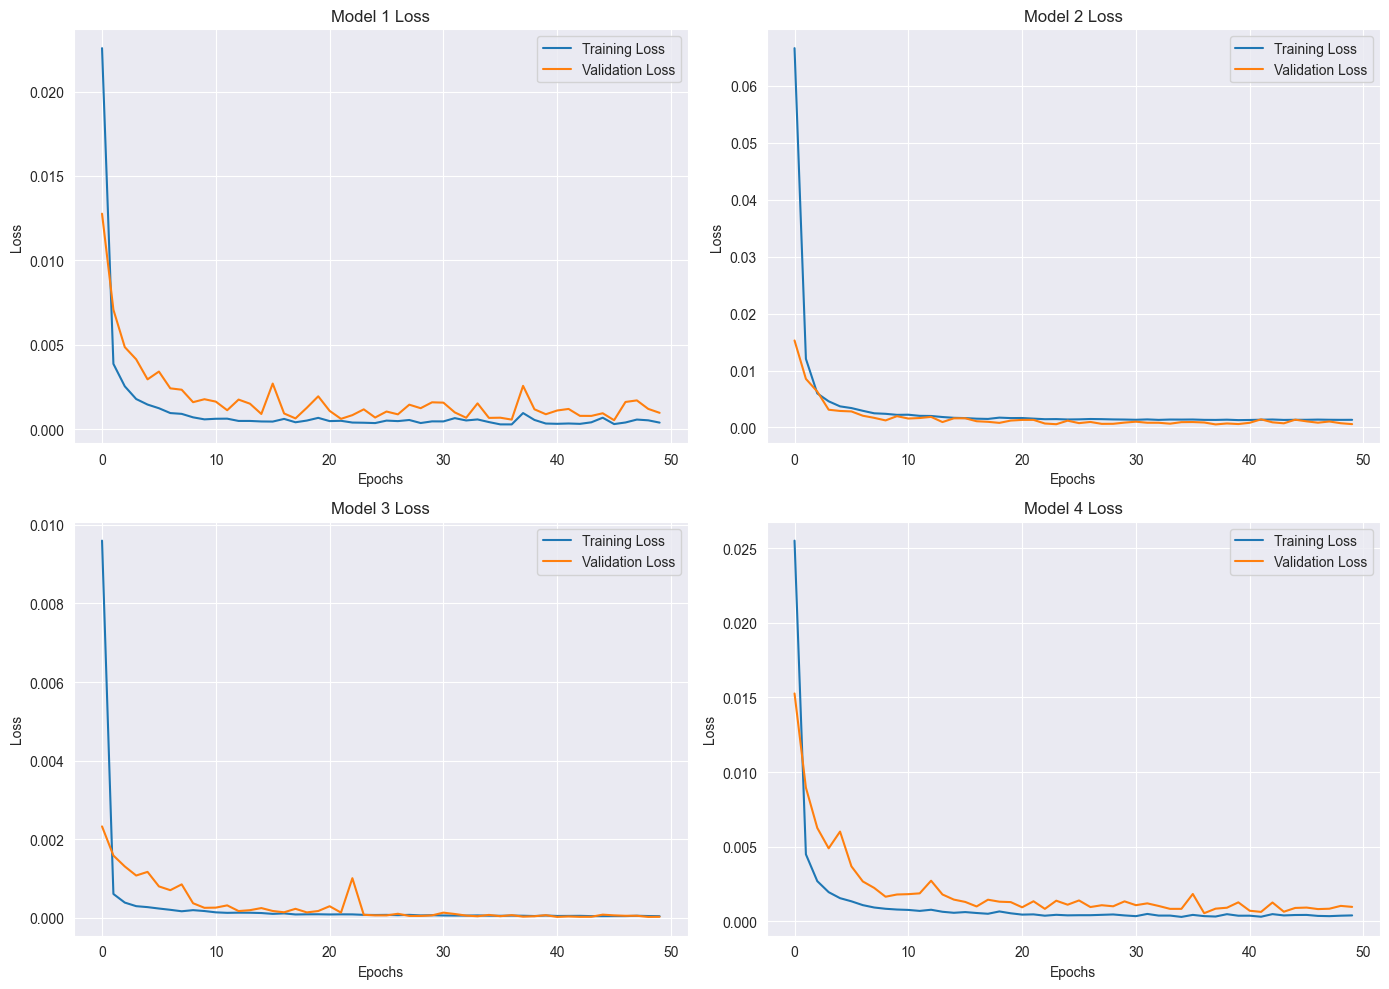

In [28]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Prepare data for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]['close']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(normalized_data, seq_length)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and train models
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_test, y_test), verbose=1)
    return history

# Model 1: Basic LSTM Model
model_1 = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Model 2: LSTM Model with Dropout
model_2 = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

# Model 3: Stacked LSTM Model
model_3 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Model 4: Bidirectional LSTM Model
model_4 = Sequential([
    Bidirectional(LSTM(50, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Train all models and store histories
history_1 = train_model(model_1, X_train, y_train, X_test, y_test)
history_2 = train_model(model_2, X_train, y_train, X_test, y_test)
history_3 = train_model(model_3, X_train, y_train, X_test, y_test)
history_4 = train_model(model_4, X_train, y_train, X_test, y_test)

# Evaluate models
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    return mse, mae

mse_1, mae_1 = evaluate_model(model_1, X_test, y_test)
mse_2, mae_2 = evaluate_model(model_2, X_test, y_test)
mse_3, mae_3 = evaluate_model(model_3, X_test, y_test)
mse_4, mae_4 = evaluate_model(model_4, X_test, y_test)

print(f'Model 1 - MSE: {mse_1}, MAE: {mae_1}')
print(f'Model 2 - MSE: {mse_2}, MAE: {mae_2}')
print(f'Model 3 - MSE: {mse_3}, MAE: {mae_3}')
print(f'Model 4 - MSE: {mse_4}, MAE: {mae_4}')

# Plot training and validation loss for each model
plt.figure(figsize=(14, 10))

for i, history in enumerate([history_1, history_2, history_3, history_4], 1):
    plt.subplot(2, 2, i)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


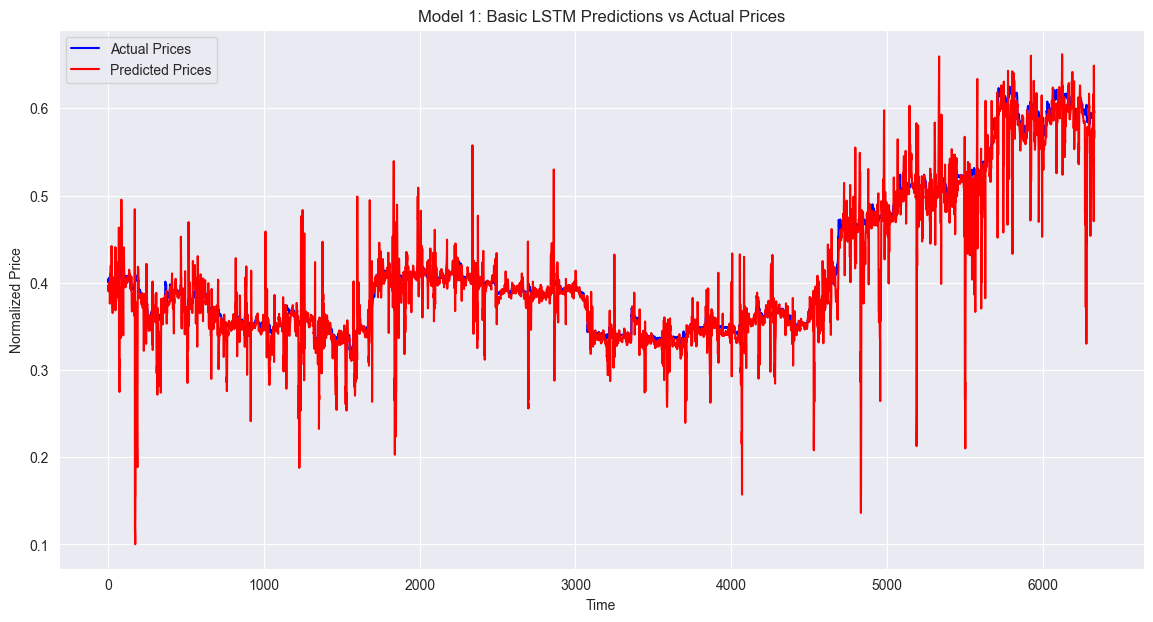

198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


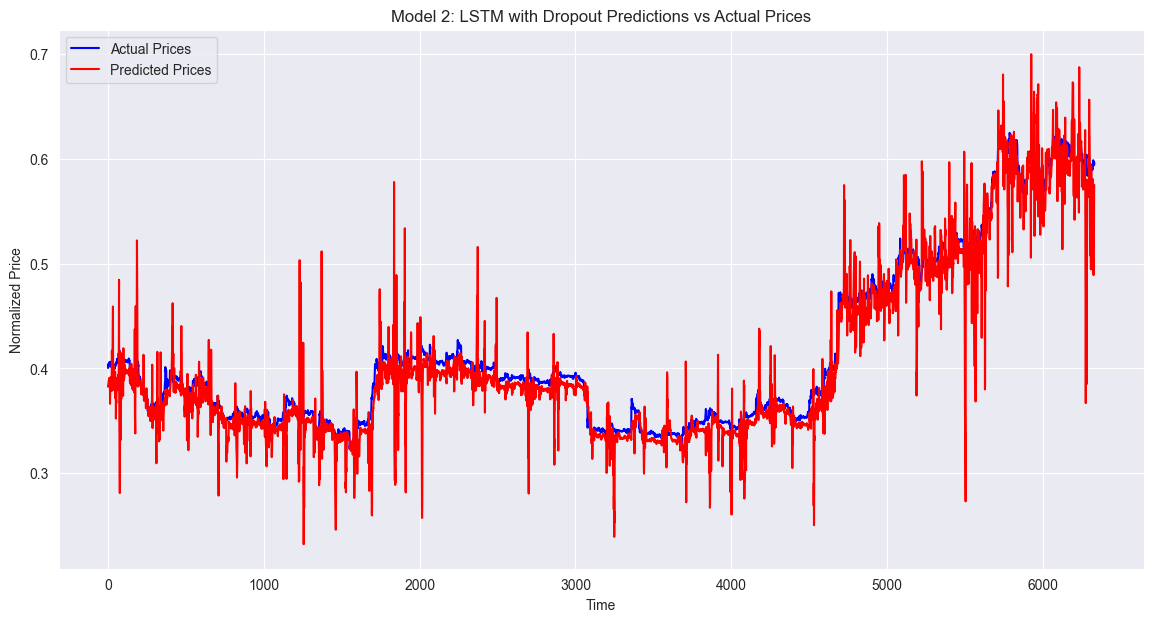

198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


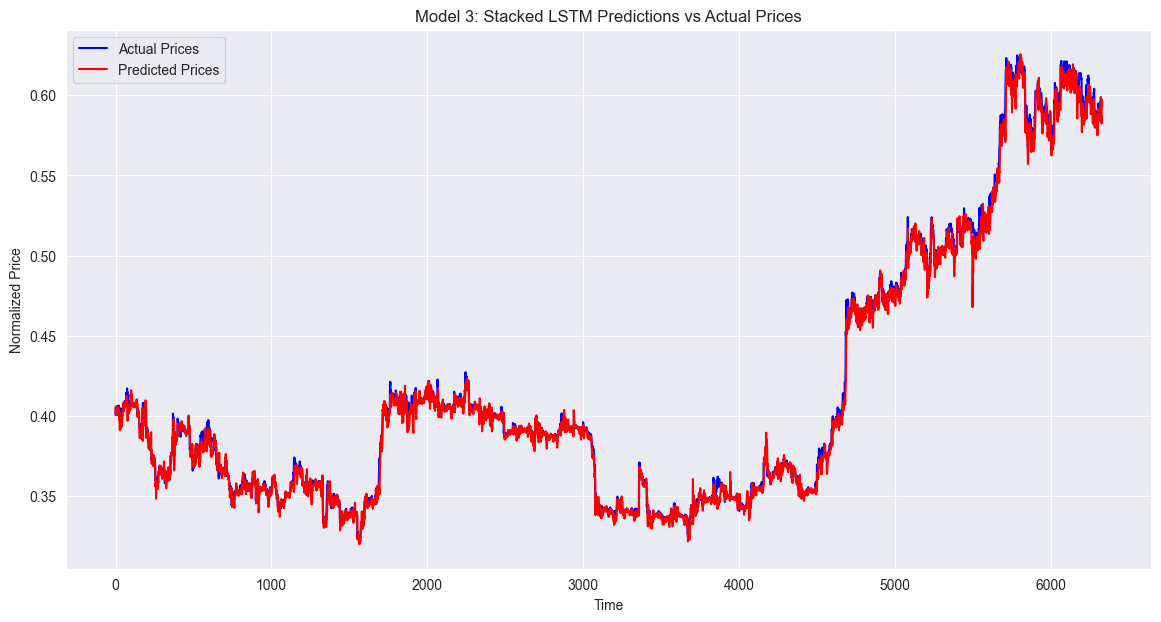

198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


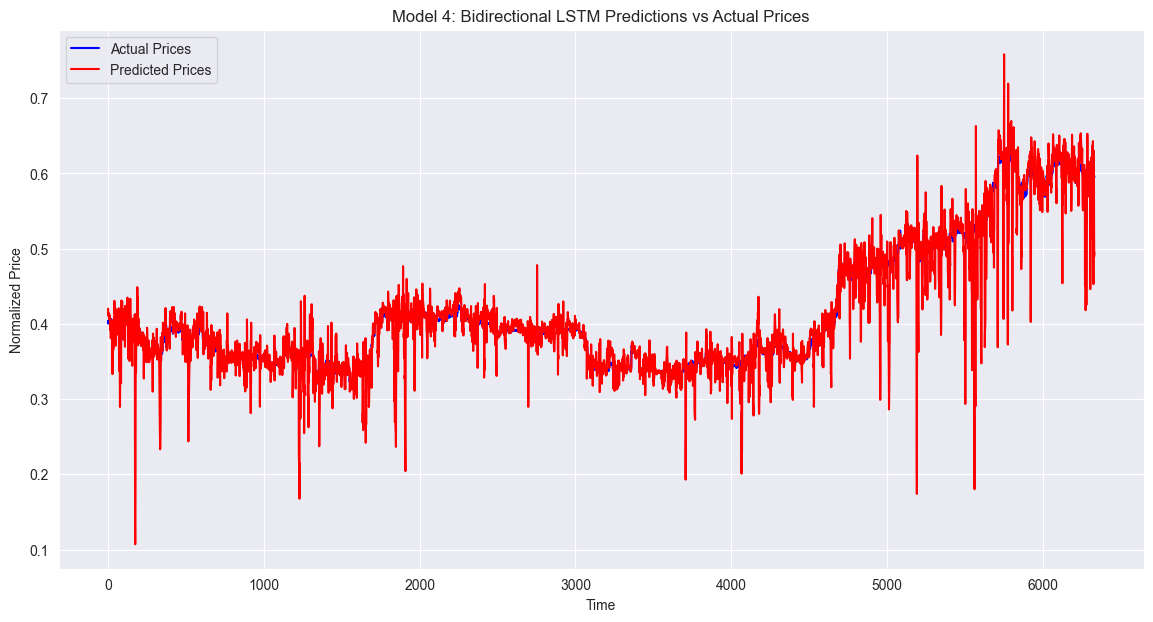

In [29]:
import matplotlib.pyplot as plt

# Define a function to plot predictions vs actual values
def plot_predictions(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.title(f'{model_name} Predictions vs Actual Prices')
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

# Plot predictions for each model
plot_predictions(model_1, X_test, y_test, 'Model 1: Basic LSTM')
plot_predictions(model_2, X_test, y_test, 'Model 2: LSTM with Dropout')
plot_predictions(model_3, X_test, y_test, 'Model 3: Stacked LSTM')
plot_predictions(model_4, X_test, y_test, 'Model 4: Bidirectional LSTM')
do

In [36]:
# Retrieve the OHLC data for the new dataset
symbol_new = 'BTCUSD'  # Example for a different symbol
timeframe_new = mt5.TIMEFRAME_H1
start_datetime_new = datetime(2024, 1, 1)
end_datetime_new = datetime(2024, 5, 15)
ohlc_df_new = get_ohlc(symbol_new, timeframe_new, start_datetime_new, end_datetime_new)

In [37]:
# Preprocess the new dataset
scaler_new = MinMaxScaler()
normalized_data_new = scaler_new.fit_transform(ohlc_df_new[['open', 'high', 'low', 'close', 'tick_volume']])
normalized_data_new = pd.DataFrame(normalized_data_new, columns=['open', 'high', 'low', 'close', 'tick_volume'])


In [38]:

# Calculate technical indicators for the new dataset
normalized_data_new['SMA_30'] = talib.SMA(normalized_data_new['close'], timeperiod=30)
normalized_data_new['SMA_50'] = talib.SMA(normalized_data_new['close'], timeperiod=50)
normalized_data_new['EMA_30'] = talib.EMA(normalized_data_new['close'], timeperiod=30)
normalized_data_new['EMA_50'] = talib.EMA(normalized_data_new['close'], timeperiod=50)
normalized_data_new['RSI_14'] = talib.RSI(normalized_data_new['close'], timeperiod=14)
normalized_data_new['MACD'], normalized_data_new['MACD_Signal'], normalized_data_new['MACD_Hist'] = talib.MACD(normalized_data_new['close'], fastperiod=12, slowperiod=26, signalperiod=9)
normalized_data_new['Upper_BB'], normalized_data_new['Middle_BB'], normalized_data_new['Lower_BB'] = talib.BBANDS(normalized_data_new['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
normalized_data_new['ATR_14'] = talib.ATR(normalized_data_new['high'], normalized_data_new['low'], normalized_data_new['close'], timeperiod=14)
normalized_data_new['SlowK'], normalized_data_new['SlowD'] = talib.STOCH(normalized_data_new['high'], normalized_data_new['low'], normalized_data_new['close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)


In [39]:
# Drop rows with NaN values resulting from indicator calculations
normalized_data_new = normalized_data_new.dropna()

In [40]:
# Additional feature engineering for the new dataset
normalized_data_new['Price_Change'] = normalized_data_new['close'].pct_change()
normalized_data_new['Volatility'] = normalized_data_new['close'].rolling(window=30).std()
normalized_data_new['Volume_Change'] = normalized_data_new['tick_volume'].pct_change()


In [41]:
# Drop rows with NaN values resulting from new feature calculations
normalized_data_new = normalized_data_new.dropna()

In [42]:
# Prepare sequences for LSTM for the new dataset
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]['close']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length_new = 60
X_new, y_new = create_sequences(normalized_data_new, seq_length_new)


In [43]:
# Use the previously developed model (model_3) to make predictions on the new dataset
predictions_new = model_3.predict(X_new)

97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [45]:
# Evaluate the predictions
mse_new = mean_squared_error(y_new, predictions_new)
mae_new = mean_absolute_error(y_new, predictions_new)
print(f'Previous Model on New Dataset - MSE: {mse_new}, MAE: {mae_new}')

Previous Model on New Dataset - MSE: 0.0003751736306746273, MAE: 0.014516923820103392


In [92]:
# Trading strategy development with take profit and stop loss
def trading_strategy(predictions, actual_prices, take_profit=0.05, stop_loss=0.02):
    initial_balance = 1000  # Initial balance in dollars
    balance = initial_balance
    position = 0  # Number of assets held
    buy_price = 0  # Price at which the asset was bought
    returns = []

    for i in range(len(predictions) - 1):
        if predictions[i] < actual_prices[i] and position == 0:
            # Buy signal
            position = balance / actual_prices[i]
            balance = 0
            buy_price = actual_prices[i]
        elif position > 0:
            # Check for take profit or stop loss
            if actual_prices[i] >= buy_price * (1 + take_profit) or actual_prices[i] <= buy_price * (1 - stop_loss):
                # Sell signal
                balance = position * actual_prices[i]
                position = 0
        returns.append(balance + position * actual_prices[i])

    return returns, (balance + position * actual_prices[-1]) - initial_balance


In [93]:
# Evaluate the trading strategy for the new predictions
returns_new, profit_new = trading_strategy(predictions_new, y_new)
print(f'Profit from the trading strategy on the new dataset: {profit_new}')

Profit from the trading strategy on the new dataset: 343.81628802031673


In [94]:
# Analyze the variability of profitability for the new predictions
returns_new = np.array(returns_new)
volatility_new = np.std(returns_new)
print(f'Volatility of returns for the new predictions: {volatility_new}')

Volatility of returns for the new predictions: 614.9829063899942


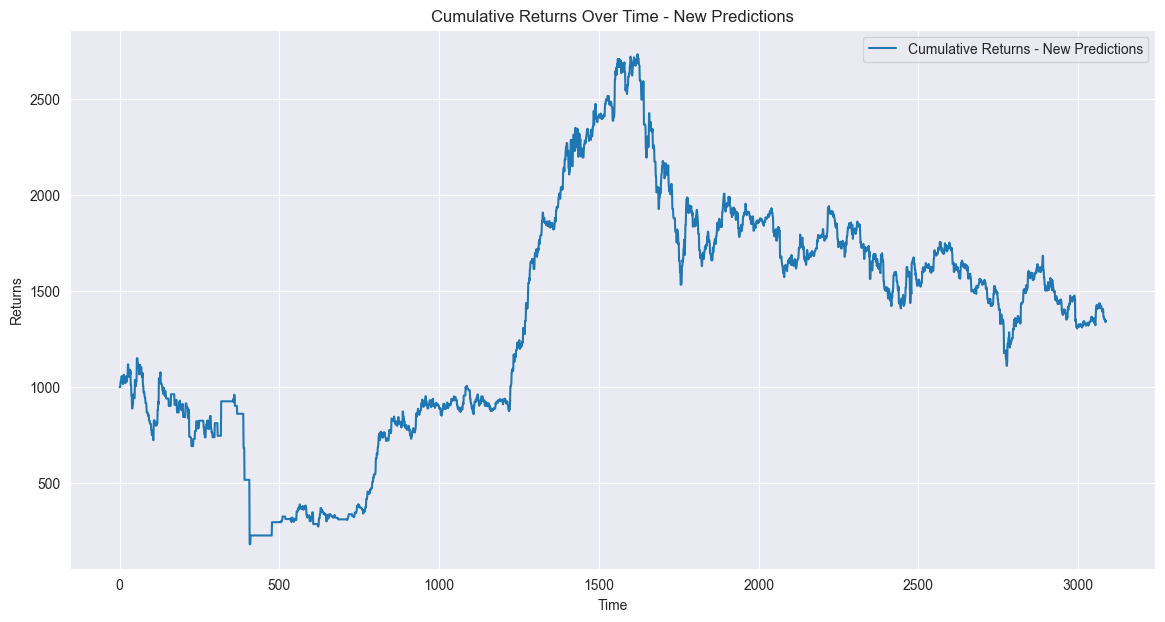

In [95]:
# Plot the cumulative returns for the new predictions
plt.figure(figsize=(14, 7))
plt.plot(returns_new, label='Cumulative Returns - New Predictions')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Cumulative Returns Over Time - New Predictions')
plt.legend()
plt.show()

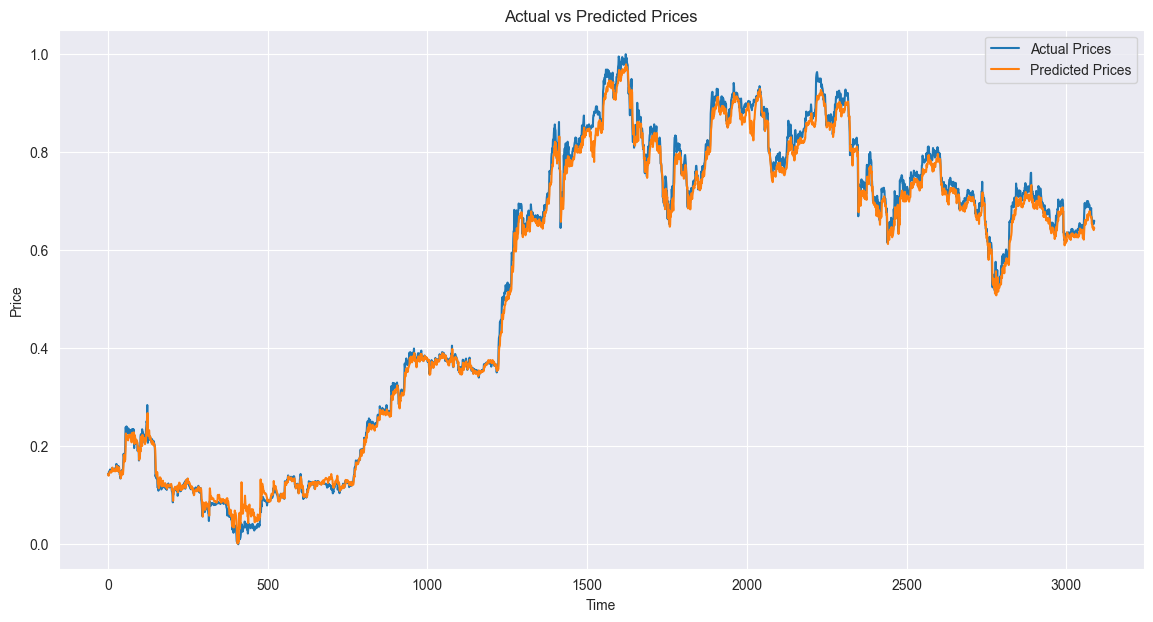

In [96]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_new, label='Actual Prices')
plt.plot(predictions_new, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

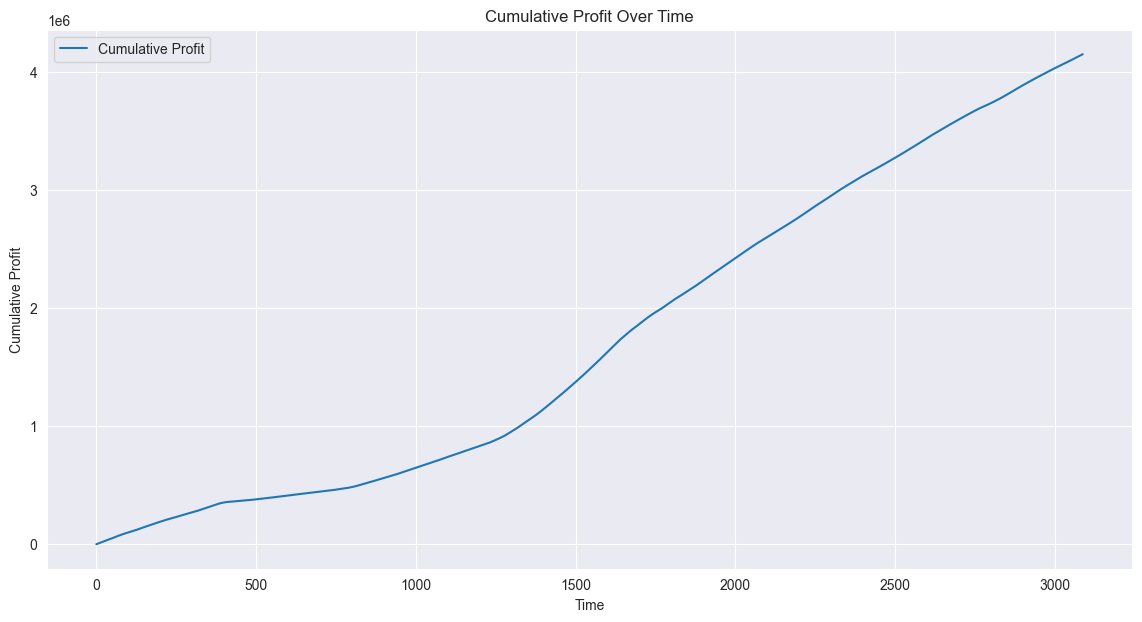

In [97]:
# Plot the cumulative profit over time
cumulative_profit = np.cumsum(returns_new)
plt.figure(figsize=(14, 7))
plt.plot(cumulative_profit, label='Cumulative Profit')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.legend()
plt.show()